In [1]:
import math
import numpy as np
import scipy.special as spf
import vegas # numeric integration
import gvar # gaussian variables; for vegas
import time
import quaternionic # For rotations
# import spherical #For Wigner D matrix
# import csv # file IO for projectFnlm
# import os.path
import numba
# import h5py # database format for mathcalI arrays
import importlib
import sys
import matplotlib.pyplot as plt

sys.path.insert(0,'../') #to load the local version of vsdm

import vsdm
from vsdm.units import *
# from vsdm.utilities import *
vsdm.__version__

'0.3.5'

# Examples of using Fnlm, EvaluateFnlm, and WaveletFnlm

This notebook has a few demonstrations of how to project a function $f(\vec u)$ onto the wavelet-harmonic basis. The fundamental object here is Fnlm, which saves the values of <f|nlm> in a dictionary, f_nlm[(n,l,m)] = <f|nlm>. Fnlm includes methods for calculating the inner product <f|nlm>, reading in saved coefficients from CSV or HDF5 files, or writing f_nlm to CSV/HDF5 files. It also provides a method for evaluating $f(\vec u)$ from the wavelet-harmonic coefficients, by defining an interpolating function for each spherical harmonic mode: Fnlm.makeInterpolator(). 

EvaluateFnlm expands the Fnlm class to make it easier to evaluate large lists of <f|nlm> coefficients, especially in parallel or on a cluster. For example, one option in EvaluateFnlm saves each <f|nlm> value to a CSV file immediately after it is calculated. When running multiple instances of EvaluateFnlm in parallel, the user can choose whether or not to save all <f|nlm> to a common CSV file. EvaluateFnlm can in principle be used with any type of radial basis function, including user-defined ones (e.g. Bessel functions, Daubechies wavelets, etc). 

WaveletFnlm takes advantage of some Haar wavelet-specific features to accelerate the EvaluateFnlm calculation. This includes a batch integration mode, which calculates all n=0,1,2...,nMax radial functions for a given harmonic mode (l,m). It also implements the "wavelet extrapolation" and adaptive methods for selecting which (if any) of the missing <f|nlm> coefficients need to be included in the wavelet-harmonic expansion. 

When calculating <f|nlm> at equivalent precision for all n < nMax, the WaveletFnlm method is expected to be faster by a factor of $\log_2 n_{max}$ (the number of wavelet generations). 

### This notebook contains four illustrative examples: 

* Example 1: how to read saved <f|nlm> coefficients from a CSV file using Fnlm. Also, how to evaluate individual <f|nlm> coefficients, using the GQUAD and VEGAS integration methods.
* Example 2: integrating <fs2|nlm> using EvaluateFnlm, for a momentum form factor.
* Example 3: integrating <fs2|nlm> using WaveletFnlm. Includes an explanation of how to use the adaptive methods. This section also shows how to convert an Fnlm object (from Example 1) into a WaveletFnlm object.
* Example 4: Gaussian-defined functions for a velocity distribution. Uses WaveletFnlm to evaluate <gX|nlm> for a large list of coefficients, for a $g_\chi(\vec v)$ defined using the GaussianF class. Using GaussianF reduces the evaluation time per coefficient by a factor of approximately 1000, taking advantage of some analytic results for the intermediate integrals.  

Examples 2 and 3 each take several minutes to run. 


### Also see:
* demo_fs2.py and demo_gX.py provide two further examples using WaveletFnlm to calculate large numbers of coefficients. These examples match the demonstrations in arXiv:2310.01483.
* SHM_gX.py evaluates <gX|nlm> for the Standard Halo Model (SHM), including the effects of annual modulation


## Form factor (box)

In [2]:
"""
    Defining the momentum form factor for the particle-in-a-box model.

    "model 4": rectangular box with dimensions (4 a0, 7 a0, 10 a0) 
        with a0 the Bohr radius
    default transition: from ground state to the n_{x,y,z} = (1, 1, 2) excited state
    "alt" transition: from ground state to the n = (3, 2, 1) excited state. 

    Both form factors are symmetric under reflections in the x, y, or z directions. 
"""

@numba.jit("double(int64,double)", nopython=True)
def fj2(nj, qLj):
    if qLj==0:
        if nj==1:
            return 1
        else:
            return 0
    qlp = np.abs(qLj)/np.pi
    # mathsinc(x) = np.sinc(x/pi)
    s_minus = np.sinc(0.5*(qlp - nj + 1))/(1 + (nj-1)/qlp)
    s_plus = np.sinc(0.5*(qlp - nj - 1))/(1 + (nj+1)/qlp)
    return (s_minus + s_plus)**2

# Long thin box limit: assuming that Lz > Lx,Ly,
# so the lowest excited states are nz=2, nz=3, with nx=ny=1.

@numba.jit("double(double[:],int64,double[:])", nopython=True)
def fs2_nz(Lvec, nz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    [Lx, Ly, Lz] = Lvec
    [qx, qy, qz] = q_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
#     qL = qLx + qLy + qLz
    fx2 = fj2(1, qLx)
    fy2 = fj2(1, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2

@numba.jit("double(double[:],int64[:],double[:])", nopython=True)
def fs2_nxyz(Lvec, n_xyz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    [Lx, Ly, Lz] = Lvec
    [qx, qy, qz] = q_xyz
    [nx, ny, nz] = n_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
    fx2 = fj2(nx, qLx)
    fy2 = fj2(ny, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2

@numba.jit("double(int64,double)", nopython=True)
def DeltaE_nz(nz, Lz):
    # for nx=ny=1 final states, in units of [q**2]/mElec
    return 0.5*math.pi**2 / mElec * (nz**2 - 1)/Lz**2

# Cartesian version of fs2:
@numba.jit("double(double[:])", nopython=True)
def fs2_model4_cart(q_xyz):
    return fs2_nz(np.array([4/qBohr, 7/qBohr, 10/qBohr]), 2, q_xyz)

# Cartesian version of fs2:
@numba.jit("double(double[:])", nopython=True)
def fs2_model4_cart_alt(q_xyz):
    Lvec = np.array([4/qBohr, 7/qBohr, 10/qBohr])
    n_xyz = np.array([3, 2, 1])
    return fs2_nxyz(Lvec, n_xyz, q_xyz)


### Defining the function fs2(qSph) that EvaluateFnlm will use as the input.
#   The function is decorated with symmetry identifiers (phi_even, phi_cyclic, etc)
#   This function is not a GaussianF instance, a sum of gaussians (is_gaussian==False) 

QMAX = 10*qBohr # Global value for q0=qMax for wavelets

# @numba.jit("double(double[:])", nopython=True)
def fs2_model4(qSph):
    [q, theta, phi] = qSph
    qx = q*math.sin(theta) * math.cos(phi)
    qy = q*math.sin(theta) * math.sin(phi)
    qz = q*math.cos(theta)
    q_xyz = np.array([qx, qy, qz])
    Lvec = np.array([4/qBohr, 7/qBohr, 10/qBohr])
    return fs2_nz(Lvec, 2, q_xyz)
fs2_model4.is_gaussian = False
fs2_model4.z_even = True
fs2_model4.phi_even = True
fs2_model4.phi_cyclic = 2

def fs2_model4_alt(qSph):
    [q, theta, phi] = qSph
    qx = q*math.sin(theta) * math.cos(phi)
    qy = q*math.sin(theta) * math.sin(phi)
    qz = q*math.cos(theta)
    q_xyz = np.array([qx, qy, qz])
    return fs2_model4_cart_alt(q_xyz)
fs2_model4_alt.is_gaussian = False
fs2_model4_alt.z_even = True
fs2_model4_alt.phi_even = True
fs2_model4_alt.phi_cyclic = 2


#

## Example 1: Import from CSV

It is simple to read in saved <f|nlm> coefficients from a CSV file using the Fnlm object. Fnlm saves information about the basis functions used for the expansion, maintains a list of evaluated <f|nlm> coefficients, and has a number of built-in methods for reading and writing CSV files. The list of coefficients is saved to the dictionary self.f_nlm, which is indexed by the coefficients (n, l, m). 

VSDM uses gvar to keep track of Gaussian integration errors on the values of <f|nlm>. This can significantly slow down operations on large lists of coefficients, so Fnlm includes an option 'use_gvar = False' to ignore this Gaussian error bar.

In [3]:
QMAX = 10*qBohr # Global value for q0=qMax for wavelets

# Define a wavelet-harmonic basis, with q0 = qMax = 10/a0:
Qbasis = dict(u0=QMAX, type='wavelet', uMax=QMAX)


In [4]:
# # Read Fnlm from saved CSV file... (for the 'alt' form factor)

csv_in = 'demo/demo_fs2_alt.csv'

wave_csv = vsdm.Fnlm(Qbasis, f_type='fs2', use_gvar=False)
wave_csv.importFnlm_csv(csv_in)
print('l_max = {}'.format(wave_csv.ellMax))
print('n_max = {}'.format(wave_csv.nMax))
print('N_coeffs = {}'.format(len(wave_csv.f_nlm.keys())))
max_fnlm = np.max([fnlm for fnlm in wave_csv.f_nlm.values()])
print('max(<f|nlm>) = {}'.format(max_fnlm))
energy_csv = wave_csv.f2nlm_norm()
print('norm_energy = {}'.format(energy_csv)) # sum of <f|nlm>**2 for all nlm

l_max = 36
n_max = 1023
N_coeffs = 194560
max(<f|nlm>) = 0.002167136503492128
norm_energy = 0.00010122865926736352


Fnlm includes a method for calculating individual coefficients: getFnlm. The result is not saved automatically to self.f_nlm.

getFnlm has two integration methods: 
    method='gquad' uses gaussian quadrature from scipy
    method='vegas' uses VEGAS Monte Carlo integration from vegas
For GQUAD, the integration parameters are the absolute and relative tolerance goals for <f|nlm>, atol_f and rtol_f. For VEGAS, one specifies instead the number of evaluation points, neval, and the number of iterations, nitn. 
    
For low-dimensional integrals, gquad tends to be faster for the same precision goal. The estimated error from gquad depends on the relative/absolute tolerance goals specified at the input (via 'integ_params'). The actual precision is often much better than the input 'epsilon', so the gvar-valued <f|nlm> tends to overestimate the error. 

For Haar wavelet basis functions, the integrator (for either method) splits the integrand into two regions "A" and "B", then returns the weighted result. getFnlm will print the outcome of the intermediate integrals, but adding the option "verbose=False" to the integ_params dictionary will suppress this output.  

In [5]:
n,l,m = (5, 4, 2)
csv_nlm_eg = wave_csv.f_nlm[(n, l, m)]
print('<f|nlm> =', csv_nlm_eg)

"""Define the integration parameters for a test of getFnlm using GQUAD method:"""
epsilon = 1e-7
integ_params = dict(method='gquad', verbose=True, atol_f=max_fnlm*epsilon, rtol_f=epsilon)

check_nlm = wave_csv.getFnlm(fs2_model4_alt, (n,l,m), integ_params)
print('Result: ', check_nlm)
print('difference: ', check_nlm - csv_nlm_eg)


<f|nlm> = -0.0014691830620357728
Calculating <f|nlm(A)> for nlm: (5, 4, 2)
-0.00038698407(17)
Calculating <f|nlm(B)> for nlm: (5, 4, 2)
0.00001968831(20)
Result:  -0.0014691831(11)
difference:  -2e-14 +- 1.1e-09


In [6]:
"""Define the integration parameters for a test of getFnlm using VEGAS instead:"""
vegas_params = dict(method='vegas', verbose=True, 
                    nitn_init=3, neval_init=3e3, # to adapt the VEGAS grid to the integrand
                    nitn=7, neval=1e5, 
                   )

check_nlm = wave_csv.getFnlm(fs2_model4_alt, (n,l,m), vegas_params)
print('Result: ', check_nlm)
print('difference: ', check_nlm - csv_nlm_eg)


Calculating <f|nlm(A)> for nlm: (5, 4, 2)
itn   integral        wgt average      chi2/dof        Q
--------------------------------------------------------
  1   -0.00038679(23) -0.00038679(23)      0.00     1.00
  2   -0.00038691(17) -0.00038687(14)      0.17     0.68
  3   -0.00038699(16) -0.00038692(11)      0.26     0.77
  4   -0.00038712(13) -0.000387001(81)     0.69     0.56
  5   -0.00038706(12) -0.000387021(67)     0.57     0.69
  6   -0.00038699(11) -0.000387012(57)     0.46     0.80
  7   -0.00038698(10) -0.000387005(50)     0.40     0.88

Calculating <f|nlm(B)> for nlm: (5, 4, 2)
itn   integral         wgt average      chi2/dof        Q
---------------------------------------------------------
  1   0.000019708(17)  0.000019708(17)      0.00     1.00
  2   0.000019682(12)  0.0000196912(98)     1.65     0.20
  3   0.0000196840(95) 0.0000196875(68)     0.96     0.38
  4   0.0000196805(97) 0.0000196852(56)     0.76     0.52
  5   0.0000196771(80) 0.0000196825(46)     0.74     0

### Interpolation and f_lm_n format

There are two ways to evaluate $f(\vec u)$ from the wavelet coeffients. The simpler method would evaluate this sum directly: 
$$f(\vec u) \simeq \sum_{n\ell m} \langle n\ell m | f \rangle \phi_{n \ell m}(\vec u).$$ 
However, this can be extremely slow, especially if the number of coefficients in self.f_nlm is very large. The faster alternative creates an Interpolator3d object for Fnlm, which defines $f(\vec u)$ as a sum of 1d radial functions $f_{\ell m}(u)$, one for each spherical harmonic: 
$$ f(\vec u) \simeq \sum_{\ell m} f_{\ell m}(u) Y_{\ell m}(\hat u),$$
with $f_{\ell m}(u)$ calculated directly from the inverse wavelet transform.

Once self.makeInterpolator has been run, the value of $f(\vec u)$ can be extracted using a built-in method, treating the class instance as a function of $\vec u$ in spherical coordinates, $\vec u = (u, \theta, \phi)$.  

In [7]:
wave_csv.makeInterpolator()
theta0 = np.pi/2
phi0 = np.pi/4
u_eg = (0.1*QMAX, theta0, phi0)
f_wavelet = wave_csv(u_eg)
f_m4alt = fs2_model4_alt(u_eg) 
print('f(u) from wavelet-harmonic expansion:', f_wavelet)
print('f(u) from original function:', f_m4alt)
print('relative error:', (f_wavelet/f_m4alt - 1))

f(u) from wavelet-harmonic expansion: 0.008414421212666716
f(u) from original function: 0.008377432884236865
relative error: 0.004415234229981024


/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_43643/1497665705.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


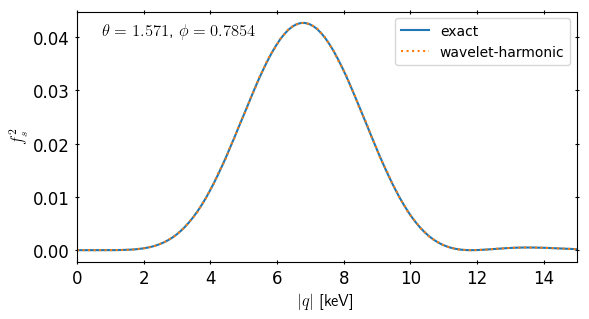

In [8]:
plotpoints = 300
u_rad = np.array([j/plotpoints * QMAX for j in range(plotpoints)])
uvecs = [(ur, theta0, phi0) for ur in u_rad]
fs2_exact = np.array([fs2_model4_alt(u) for u in uvecs])
fs2_wave = np.array([wave_csv(u) for u in uvecs])

unisize = 2.5 
fonts = 12
fig = plt.figure(figsize=[2*unisize,unisize])
ax1 = fig.add_axes([0,0,1,1], 
                   xscale='linear', yscale='linear')
ax1.plot(u_rad/keV, fs2_exact, label=r'exact')
ax1.plot(u_rad/keV, fs2_wave, label='wavelet-harmonic', linestyle='dotted')

ax1.set_xlim([0, 15])
# ax1.set_ylim([0, 0.2])
ax1.set_xlabel(r'$|q|$ [keV]', fontsize=fonts, usetex=True)
ax1.set_ylabel(r'$f_s^2$', fontsize=fonts, usetex=True)
ax1.tick_params(axis='both', labelsize=fonts, direction='inout',
                right=True, top=True)
ax1.legend(loc='upper right')

ax1.text(0.05, 0.95, r'$\theta={:.4g}$, $\phi={:.4g}$'.format(theta0, phi0), horizontalalignment='left',
         verticalalignment='top', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=ax1.transAxes, usetex=True)

fig.show()

# Example 2: EvaluateFnlm

EvaluateFnlm is the general-purpose integrator of <f|nlm> coefficients. It evaluates $\langle f | \phi_{n \ell m} \rangle$ for basis functions of the form $\phi_{n \ell m}(\vec u) = r_n(u) Y_{\ell m}(\hat u)$, for real spherical harmonics $Y_{\ell m}$. It calculates each <f|nlm> coefficient in the supplied list, optionally saving the results to a CSV file. 

EvaluateFnlm is not optimized for the wavelet basis functions. For wavelets, it is much faster to use WaveletFnlm instead. 

In [9]:
"""
    New numeric calculation with EvaluateFnlm.

    Optional: to save the values of <f|nlm> to a CSV file as they are evaluated, 
        define csvsame_name as the file path. 
    If csvsave_name is an existing file, the new values will be added to the end, 
        without overwriting the previous values. 
"""
epsilon = 1e-7
integ_params = dict(method='gquad', verbose=True, atol_f=epsilon, rtol_f=epsilon)

nMax = 23
nMin = 0
lMin = 0
lMax = 4
nlmlist_4 = vsdm.makeNLMlist(nMax, lMax, nMin=nMin, lMin=lMin,
                             phi_even=True, mSymmetry=2, lSymmetry=2)

# csvname = 'out/fs2_demo4b.csv'
waveE = vsdm.EvaluateFnlm(Qbasis, fs2_model4, integ_params, 
                          nlmlist=nlmlist_4,  
                          f_type='fs2', 
                          csvsave_name=None)
print('total evaluation time:', waveE.t_eval)
print('average evaluation time per coefficient:', waveE.t_eval/len(waveE.f_nlm.keys()))


Calculating <f|nlm> for nlm: (0, 0, 0)
0.000243478(96)
Calculating <f|nlm(A)> for nlm: (1, 0, 0)
0.000644140(93)
Calculating <f|nlm(B)> for nlm: (1, 0, 0)
-5.8(4.9)e-09
Calculating <f|nlm(A)> for nlm: (2, 0, 0)
0.001809409(32)
Calculating <f|nlm(B)> for nlm: (2, 0, 0)
-1.785(41)e-06
Calculating <f|nlm(A)> for nlm: (3, 0, 0)
2.15(26)e-08
Calculating <f|nlm(B)> for nlm: (3, 0, 0)
-8(67)e-10
Calculating <f|nlm(A)> for nlm: (4, 0, 0)
0.003173323841(53)
Calculating <f|nlm(B)> for nlm: (4, 0, 0)
-0.000277780(72)
Calculating <f|nlm(A)> for nlm: (5, 0, 0)
6.712(99)e-06
Calculating <f|nlm(B)> for nlm: (5, 0, 0)
-1.71(58)e-07
Calculating <f|nlm(A)> for nlm: (6, 0, 0)
2.7(3.1)e-08
Calculating <f|nlm(B)> for nlm: (6, 0, 0)
-4(26)e-09
Calculating <f|nlm(A)> for nlm: (7, 0, 0)
1.0(8.5)e-09
Calculating <f|nlm(B)> for nlm: (7, 0, 0)
-4(35)e-10
Calculating <f|nlm(A)> for nlm: (8, 0, 0)
0.0011235534688097(29)
Calculating <f|nlm(B)> for nlm: (8, 0, 0)
-0.001121708823(22)
Calculating <f|nlm(A)> for nlm: (

# Example 3: WaveletFnlm

Rather than calculating <f|nlm> independently for every wavelet coefficient, it is generally much faster to use the discrete wavelet transform instead. As an intermediate step, WaveletFnlm defines a set of $2^N$ "tophat" basis functions (nonzero only within a narrow region) and evaluates $\langle f | n' \ell m \rangle$ in that basis. At the end, the tophat basis is converted to a wavelet basis via a discrete transform. 

This is as fast as evaluating all <f|nlm> for a single generation of wavelets. Compared to EvaluateFnlm, WaveletFnlm is faster by a factor of approximately $\log_2 n_{max}$. So, WaveletFnlm is always the recommended method if the radial functions $r_n(u)$ are spherical Haar basis functions. 

### Adaptive Methods

WaveletFnlm also supports an adaptive method based on polynomial wavelet extrapolation. This uses the values of already-evaluated <f|nlm> to estimate the values of larger-n coefficients. This estimation procedure becomes precise when the wavelets |n> are narrow compared to the variation in $f(u)$. 

The adaptive method begins by integrating <f|nlm> for an initial sample of $n = 0, 1, \ldots, 2^N - 1$ radial functions for each $(\ell, m)$. Then, the values of <f|nlm> for $n = 2^{N-1}, \ldots, 2^N - 1$ are estimated from the $n < 2^{N-1}$ coefficients using the polynomial wavelet extrapolation. Where the predicted and actual values of <f|nlm> match (within a specified precision goal), no further integration is needed. If there are regions of radial coordinate $u$ where the wavelet extrapolation is imprecise, then this indicates that more <f|nlm> coefficients need to be calculated. WaveletFnlm integrates <f|nlm> for the necessary values of n, until the polynomial wavelet extrapolation meets the precision goal. 

This process can be performed in parallel for different angular indices $(\ell, m)$, via the functions WaveletFnlm.initialize_lm() and WaveletFnlm.refine_lm(). 

In [10]:
"""
    New numeric calculation with WaveletFnlm.

    power2_lm: specifies the number of wavelet generations to calculate for each (l, m) 
        during initialization.
    porder: polynomial order for wavelet extrapolation, and for Interpolator objects.
        0 for no extrapolation; 1 for linear; 3 for cubic 
    epsilon, atol_f2norm, atol_fnlm: relative and absolute tolerance goals 
    refine_at_init: whether to perform the adaptive integration steps at initialization 
    max_depth: maximum number of iterations to attempt during 'refine' step 
    import_fnlm: (optional) import a dict of <f|nlm> coefficients into self.f_nlm at initialization
    csvsave_name: (optional) file name for saving <f|nlm> coefficients 

    Methods: 
    initialize_lm(lm, power2): calculates initial batch of <f|nlm> coefficients for n < 2^power2
    refine_lm(lm, max_depth): tests accuracy of wavelet extrapolation, 
        calculates new <f|nlm> as needed.
    """
epsilon = 1e-5
integ_params = dict(method='gquad', verbose=True, atol_f=max_fnlm*epsilon, rtol_f=epsilon)

# initialize class without performing any integrals:
wave_extp = vsdm.WaveletFnlm(Qbasis, fs2_model4, integ_params,
                             power2_lm={}, p_order=3,
                             epsilon=epsilon,
                             atol_f2norm=energy_csv*1e-5,
                             atol_fnlm=max_fnlm*1e-3,
                             refine_at_init=False,
                             # max_depth=5,
                             f_type='fs2',
                             csvsave_name=None,
                             use_gvar=True)

lmlist = [(0,0), (2,0), (2,2), (4,0), (4,2), (4,4)]
power2 = 5 # includes n=0,1,...,31 in initial batch
t0 = time.time() 
for lm in lmlist: 
    wave_extp.initialize_lm(lm, power2)
tEval = time.time() - t0
print('total evaluation time:', tEval)
print('average evaluation time per coefficient:', tEval/len(wave_extp.f_nlm.keys()))


Calculating <f|nlm> for nlm: (0, 0, 0)
0.0001568230772680591(29)
Calculating <f|nlm> for nlm: (1, 0, 0)
0.0012247875554558(33)
Calculating <f|nlm> for nlm: (2, 0, 0)
0.00241915400351(63)
Calculating <f|nlm> for nlm: (3, 0, 0)
0.002169615008(85)
Calculating <f|nlm> for nlm: (4, 0, 0)
0.0011643817(13)
Calculating <f|nlm> for nlm: (5, 0, 0)
0.0004860538(11)
Calculating <f|nlm> for nlm: (6, 0, 0)
0.00018576876(77)
Calculating <f|nlm> for nlm: (7, 0, 0)
0.0000619558529(29)
Calculating <f|nlm> for nlm: (8, 0, 0)
0.000015986327(13)
Calculating <f|nlm> for nlm: (9, 0, 0)
2.4644820(21)e-06
Calculating <f|nlm> for nlm: (10, 0, 0)
2.730066(59)e-07
Calculating <f|nlm> for nlm: (11, 0, 0)
3.46462(38)e-07
Calculating <f|nlm> for nlm: (12, 0, 0)
3.85546(38)e-07
Calculating <f|nlm> for nlm: (13, 0, 0)
1.98205(39)e-07
Calculating <f|nlm> for nlm: (14, 0, 0)
4.5441(43)e-08
Calculating <f|nlm> for nlm: (15, 0, 0)
7.175(48)e-09
Calculating <f|nlm> for nlm: (16, 0, 0)
2.3326(50)e-08
Calculating <f|nlm> for

In [11]:
"""
    See if wave_extp includes enough coefficients to use the adaptive method.
    * if most wavelet blocks are "diverging", then n_max is not large enough. 
    * recommend starting with n_max such that most blocks are "converging" at this step. 
"""
wave_extp.diagnose_convergence((2,0))


Converging blocks:
  n	Generations to go until convergence:
Diverging blocks:
  n	Generations to go until convergence:
  8	1.345681930885397
  9	2.287875143449442
  10	4.9319708023503255
  11	2.045413227576503
  12	1.966023077085663
  13	0.1062767313709505
  14	2.7014417839981935
  15	0.526740532771839


In [12]:
"""
    See if wave_csv includes enough coefficients to use the adaptive method.
    * First, convert Fnlm into a WaveletFnlm object. 
    * It may take a few minutes to create the Interpolation objects for each (l,m). 
"""
# initialize WaveletFnlm class from previously imported wave_csv:
lm_list = wave_csv.lm_index # the list of (l,m) modes included in wave_csv 
power2 = int(np.log2(wave_csv.nMax)) + 1
power2_lm = {lm:power2 for lm in lm_list}
t0 = time.time()
wave_csv2 = vsdm.WaveletFnlm(Qbasis, fs2_model4_alt, integ_params,
                             import_fnlm=wave_csv.f_nlm, # import all coeffs from wave_csv
                             power2_lm=power2_lm, # at init, run initialize_lm() for these (l,m)
                             p_order=3,
                             epsilon=epsilon,
                             atol_f2norm=energy_csv*1e-5,
                             atol_fnlm=max_fnlm*1e-3,
                             refine_at_init=False,
                             f_type='fs2',
                             use_gvar=False)
tInit = time.time() - t0
print(tInit)

394.9040582180023


In [13]:
# Now that wave_csv2 is initialized, can use adaptive wavelet methods:  
wave_csv2.diagnose_convergence((2,0))

Converging blocks:
  n	Generations to go until convergence:
  261	-0.18588132698186177
  262	-0.4395753413823463
  263	-0.6608515322172264
  264	-0.8585938499135337
  265	-1.038770578271029
  266	-1.2056292619822493
  267	-1.362347321952644
  268	-1.511415254505633
  269	-1.6548794803423037
  270	-1.7945091793019436
  271	-1.9319233905161786
  272	-2.068702355620335
  273	-2.206503628690952
  274	-2.3472075833788604
  275	-2.493132218293651
  276	-2.6473965545319733
  277	-2.814616033774374
  278	-3.002422937219714
  279	-3.225422705213592
  280	-3.5186917898417316
  281	-4.017920504283178
  282	-4.473645374295958
  283	-3.8469095283149133
  284	-3.641438432844856
  285	-3.5358046773613108
  286	-3.4763508546335182
  287	-3.443830526472219
  288	-3.429182350503035
  289	-3.427467418782608
  290	-3.4357446534694223
  291	-3.452167633054374
  292	-3.4755496022273857
  293	-3.505136265095491
  294	-3.540482136687947
  295	-3.5813930664637383
  296	-3.627854177053228
  297	-3.6801139942360

The function diagnose_convergence() calculates the local values of f(u) and its first $p$ derivatives from the wavelet coefficients, and estimates the number of additional wavelet generations that must be calculated before the higher derivatives start becoming irrelevantly small. This is independent of the precision goals atol_fnlm and atol_f2norm. 

To see how well the <f|nlm> estimations match the calculated values, use check_extrap_accuracy. If verbose=True, it prints out the values and polynomial estimates of <f|nlm> for all n in the last wavelet generation. This function also returns a list of the wavelet blocks where the wavelet extrapolation method is insufficiently accurate. 

If the list of inaccurate coefficients is not empty, then the function refine_lm() can be used to integrate the necessary additional <f|nlm> coefficients. For the form factor in this example, nMax=1023 is large enough that the wavelet extrapolation is already sufficiently accurate everywhere.

In [14]:
wave_csv2.check_extrap_accuracy((2,0))

Accuracy goal: atol_fnlm = 2.1671365034921278e-06
n=512	f_actual: 3.80364e-18 	f_est: 1.77459e-15
	f_diff: -1.7707822e-15
n=513	f_actual: 1.10847e-15 	f_est: -1.00164e-15
	f_diff: 2.1101089e-15
n=514	f_actual: 2.09616e-14 	f_est: 2.49797e-14
	f_diff: -4.0180655e-15
n=515	f_actual: 1.51763e-13 	f_est: 1.36573e-13
	f_diff: 1.5190414e-14
n=516	f_actual: 6.729e-13 	f_est: 8.37245e-13
	f_diff: -1.6434465e-13
n=517	f_actual: 2.21693e-12 	f_est: 2.13288e-12
	f_diff: 8.4042942e-14
n=518	f_actual: 5.98538e-12 	f_est: 6.08464e-12
	f_diff: -9.9268876e-14
n=519	f_actual: 1.40098e-11 	f_est: 1.3739e-11
	f_diff: 2.7083855e-13
n=520	f_actual: 2.94525e-11 	f_est: 3.02375e-11
	f_diff: -7.85e-13
n=521	f_actual: 5.69402e-11 	f_est: 5.65686e-11
	f_diff: 3.7169804e-13
n=522	f_actual: 1.02924e-10 	f_est: 1.03333e-10
	f_diff: -4.0911309e-13
n=523	f_actual: 1.76054e-10 	f_est: 1.75007e-10
	f_diff: 1.0467132e-12
n=524	f_actual: 2.87569e-10 	f_est: 2.89544e-10
	f_diff: -1.9750774e-12
n=525	f_actual: 4.51679e-10

[]

In [15]:
wave_csv2.refine_lm((2,0), max_depth=2)
# for the CSV file, nothing to do here

# Example 4: Gaussian functions (Velocity distribution)

In this example, the function gX(v) is defined as the sum of several Gaussians, 
with different widths, centered at different lab-frame velocities. 

Compared to the momentum form factor, this gaussian-defined function can be evaluated extremely quickly. For every $\ell$, a single series of 1d integrals is sufficient to calculate <f|nlm> for all $-\ell \leq m \leq \ell$. 

In [16]:

"""Parameters for 'Model 4': """

def gaussian_stream_sum(ci, vWsph_i, sigma_i):
    # Arguments: lists of amplitudes gi, dispersions v0_i, and
    #     lab-frame DM wind vectors vWsph_i, in spherical coordinates
    gvec_list = []
    for i in range(len(gi)):
        gaus = (ci[i], vWsph_i[i], sigma_i[i])
        gvec_list += [gaus]
    return gvec_list

# Model 4: a bunch of streams, not symmetric.
# Including a halo component without vEsc.
v0_main = 220*km_s
v0_a = 70*km_s
v0_b = 50*km_s
v0_c = 25*km_s
vX_main = vsdm.cart_to_sph((0, 0, -230*km_s))
vX_a = vsdm.cart_to_sph((80*km_s, 0, -80*km_s))
vX_b = vsdm.cart_to_sph((-120*km_s, -250*km_s, -150*km_s))
vX_c = vsdm.cart_to_sph((50*km_s, 30*km_s, -400*km_s))
sigma_i = [v0_main, v0_a, v0_b, v0_c]
vWsph_i = [vX_main, vX_a, vX_b, vX_c]
gi = [0.4, 0.3, 0.2, 0.1]
gvec_list_4 = gaussian_stream_sum(gi, vWsph_i, sigma_i)

VMAX = 960.*km_s # Global value for v0=vMax for wavelets
basisV = dict(u0=VMAX, type='wavelet', uMax=VMAX)
gXmodel_4 = vsdm.Gnli(basisV, gvec_list_4)

# Define a function to convert GaussianF(gX) into GaussianF(tilde_gX),
# for dimensionless function tilde_gX = u0**3 * gX,
# where u0 is the vsdm.Basis.u0 scale factor
def gX_to_tgX(gauF, u0):
    tgauF_vecs = gauF.rescaleGaussianF(u0**3)
    return vsdm.Gnli(gauF.basis, tgauF_vecs)

gXmodel = gX_to_tgX(gXmodel_4, VMAX)
gvec_tilde_4 = gXmodel.gvec_list

gXmodel.is_gaussian = True


In [17]:
power2 = 8
l_max = 12

energy = gXmodel.norm_energy()
print("energy: ", energy)

Vdict = dict(u0=VMAX, type='wavelet', uMax=VMAX)
epsilon = 1e-8
atol_E = energy * epsilon
atol_f = 0.05 * math.sqrt(atol_E)
integ_params = dict(method='gquad', verbose=False,
                    atol_f=0.01*atol_f,
                    rtol_f=epsilon)
t0 = time.time()
wave_gaus = vsdm.WaveletFnlm(Vdict, gXmodel, integ_params,
                             power2_lm={}, p_order=3,
                             epsilon=epsilon,
                             atol_f2norm=atol_E,
                             atol_fnlm=atol_f,
                             f_type='gX',
                             use_gvar=True)

lm_list = [(l, m) for l in range(l_max+1) for m in range(-l, l+1)]
t0_lm = {}
for lm in lm_list:
    t_lm = time.time()
    wave_gaus.initialize_lm(lm, power2)
    t0_lm[lm] = time.time() - t_lm
    print("\ttEval[{}]:".format(lm), t0_lm[lm])
tTot = time.time() - t0
print('total evaluation time:', tTot)
print('average evaluation time per coefficient:', tTot/len(wave_gaus.f_nlm.keys()))


energy:  72.35077492752438
	tEval[(0, 0)]: 0.3257462978363037
	tEval[(1, -1)]: 0.28070807456970215
	tEval[(1, 0)]: 0.312697172164917
	tEval[(1, 1)]: 0.29332804679870605
	tEval[(2, -2)]: 0.2809751033782959
	tEval[(2, -1)]: 0.2656681537628174
	tEval[(2, 0)]: 0.31463027000427246
	tEval[(2, 1)]: 0.3043978214263916
	tEval[(2, 2)]: 0.29233217239379883
	tEval[(3, -3)]: 0.2766749858856201
	tEval[(3, -2)]: 0.27356886863708496
	tEval[(3, -1)]: 0.2778921127319336
	tEval[(3, 0)]: 0.3098311424255371
	tEval[(3, 1)]: 0.2982139587402344
	tEval[(3, 2)]: 0.29570698738098145
	tEval[(3, 3)]: 0.2969658374786377
	tEval[(4, -4)]: 0.2833726406097412
	tEval[(4, -3)]: 0.2805750370025635
	tEval[(4, -2)]: 0.26848793029785156
	tEval[(4, -1)]: 0.277249813079834
	tEval[(4, 0)]: 0.31131577491760254
	tEval[(4, 1)]: 0.2930889129638672
	tEval[(4, 2)]: 0.28816795349121094
	tEval[(4, 3)]: 0.29969024658203125
	tEval[(4, 4)]: 0.30000996589660645
	tEval[(5, -5)]: 0.2784299850463867
	tEval[(5, -4)]: 0.27157020568847656
	tEval

/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_43643/2947224940.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


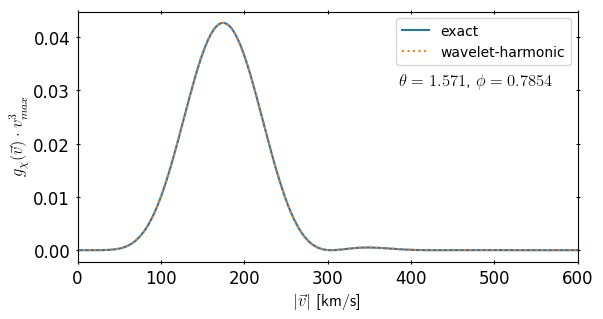

In [18]:
wave_gaus.makeInterpolator()

plotpoints = 300
u_rad = np.array([j/plotpoints * VMAX for j in range(plotpoints)])
uvecs = [(ur, theta0, phi0) for ur in u_rad]
gX_exact = np.array([gXmodel.gU(u) for u in uvecs])
gX_wave = np.array([wave_gaus(u) for u in uvecs])

unisize = 2.5 
fonts = 12
fig = plt.figure(figsize=[2*unisize,unisize])
ax1 = fig.add_axes([0,0,1,1], 
                   xscale='linear', yscale='linear')
ax1.plot(u_rad/km_s, fs2_exact, label=r'exact')
ax1.plot(u_rad/km_s, fs2_wave, label='wavelet-harmonic', linestyle='dotted')

ax1.set_xlim([0, 600])
# ax1.set_ylim([0, 0.2])
ax1.set_xlabel(r'$|\vec v|$ [km/s]', fontsize=fonts, usetex=True)
ax1.set_ylabel(r'$g_\chi(\vec v) \cdot v_{max}^3$', fontsize=fonts, usetex=True)
ax1.tick_params(axis='both', labelsize=fonts, direction='inout',
                right=True, top=True)
ax1.legend(loc='upper right')

ax1.text(0.95, 0.75, r'$\theta={:.4g}$, $\phi={:.4g}$'.format(theta0, phi0), 
         horizontalalignment='right',
         verticalalignment='top', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=ax1.transAxes, usetex=True)

fig.show()